In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile,exception_verbosity=high'

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

import keras.models as models
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.advanced_activations import ELU

from keras import backend as K

import cv2
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)
Using Theano backend.


In [3]:
K.set_image_dim_ordering('tf')

### Get decoder from VGG16

In [4]:
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model.save_weights('theano_weight_tf.h5')

## Segnet

In [5]:
#input image configuration
img_height = 224
img_width = 448
img_channels = 3

#NN configuration
kernel_size = (3, 3)
filter_size = 64
pool_size = (2,2)

In [6]:
def add_conv_batchnorm_input(model, filter_size, input_shape):
    model.add(Convolution2D(filter_size, (3, 3), activation=None, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

In [7]:
def add_conv_batchnorm(model, filter_size):
    model.add(Convolution2D(filter_size, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

In [8]:
def get_encoder(model):
    add_conv_batchnorm_input(model, 64, (img_height, img_width, 3))
    add_conv_batchnorm(model, 64)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    add_conv_batchnorm(model, 128)
    add_conv_batchnorm(model, 128)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    add_conv_batchnorm(model, 256)
    add_conv_batchnorm(model, 256)
    add_conv_batchnorm(model, 256)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    model.add(MaxPooling2D(pool_size=pool_size))

In [9]:
from keras.utils import layer_utils

In [10]:
idx_old = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]
idx_new = [0, 3, 7, 10, 14, 17, 20, 24, 27, 30, 34, 37, 40]

In [11]:
#get decoder weights from vgg

import h5py

weights_path = 'theano_weight_tf.h5'

f = h5py.File(weights_path)
 
layer_names = [name for name in f.attrs['layer_names']]

model = models.Sequential()
get_encoder(model)

for i, k in enumerate(idx_new):
        g = f[layer_names[idx_old[i]]]
        weights = [g[name] for name in g.attrs['weight_names']]
        model.layers[k].set_weights(weights)
        
print('VGG Model weights loaded.')

VGG Model weights loaded.


In [12]:
freeze_layers_num = len(model.layers)

In [13]:
#function for decoder layers
def get_decoder_layers(model):
    model.add(UpSampling2D(size=pool_size))
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    
    model.add(UpSampling2D(size=pool_size))
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    add_conv_batchnorm(model, 512)
    
    model.add(UpSampling2D(size=pool_size))
    add_conv_batchnorm(model, 256)
    add_conv_batchnorm(model, 256)
    add_conv_batchnorm(model, 256)
    
    model.add(UpSampling2D(size=pool_size))
    add_conv_batchnorm(model, 128)
    add_conv_batchnorm(model, 128)
    
    model.add(UpSampling2D(size=pool_size))
    add_conv_batchnorm(model, 64)
    add_conv_batchnorm(model, 64)

In [14]:
#add decoder layers
get_decoder_layers(model)

data_shape = img_height * img_width

#add classfication layer
model.add(Convolution2D(12, (1, 1), padding='same'))
model.add(Reshape((12,data_shape)))
model.add(Permute((2, 1)))
model.add(Activation('softmax'))

In [15]:
#compile model
model.compile(loss="categorical_crossentropy", optimizer='adam')

### Test if all correct

In [16]:
a = model.predict(np.zeros((1,img_height, img_width, 3)))

In [17]:
a.shape

(1, 100352, 12)

## Data preprocessing

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
from skimage.io import imread
img = imread('aachen_000000_000019_gtFine_color.png')

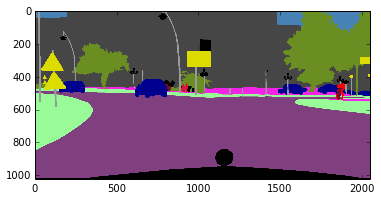

In [20]:
plt.imshow(img)

In [22]:
from skimage.transform import resize
img_resized = resize(img, (224, 448))

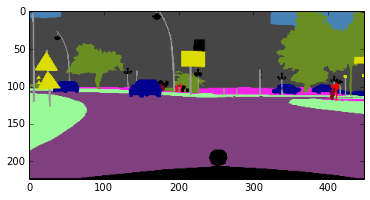

In [23]:
plt.imshow(img_resized)